# Pipeline for analyzing flow cytometry data

In [1]:
from FlowCytometryTools import *
import numpy as np
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import glob
import seaborn as sns

import os
import sys

path = '/Users/andrewng/Documents/AHN_FlowTools/'
if not path in sys.path:
    sys.path.insert(1, path)
del path

from AHN_FlowTools import *

sns.set_style('white')
sns.set_style('ticks')
%matplotlib inline

In [2]:
datadir = list()

datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180622_ZPMplantcomp/Plate1/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180622_ZPMplantcomp/Plate2/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180622_ZPMplantcomp/Plate3/')
datadir.append('/Users/andrewng/Documents/HES Lab/Flow Cytometry/ahn20180622_ZPMplantcomp/Plate4/')

date = '20180622'

allfiles = {}
strains = ['Plate1','Plate2','Plate3','Plate4']

for i in range(len(datadir)):
    files = glob.glob(datadir[i] + '*.fcs')
    allfiles[strains[i]] = files

In [3]:
rows = ['A','B','C','D','E','F','G','H']
cols = ['01','02','03','04','05','06','07','08','09','10','11','12']

In [4]:
plateraw = pd.DataFrame(index = rows, columns = cols)

panelDict = {strain:plateraw for strain in strains}
allplates = pd.Panel(panelDict)

In [5]:
for strain in strains:
    for f in allfiles[strain]:
        c = f[-10:-8]
        r = f[-11]
        call = r + c
        allplates[strain].set_value(r, c, FCMeasurement(ID = call, datafile = f))

In [6]:
def FCdatastats(platesort,normalized=None,rows=None,cols=None,FITCthresh=None,FSCthresh=None):

    #Calculate the linear median, mean, and SD for each of the wells. Create two different Panels, one for FITC and one
    #for mCherry. In each Panel store a DataFrame containing the median, mean, SD, and CV

    if normalized is None:
        normalized = True
    if rows is None:
        rows = ['A','B','C','D','E','F','G','H']
    if cols is None:
        cols = ['01','02','03','04','05','06','07','08','09','10','11','12']
    if FITCthresh is None:
        FITCthresh = 100
    if FSCthresh is None:
        FSCthresh = 1000

    empty = pd.DataFrame(index = rows, columns = cols)

    FITCstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty, 'cv':empty})
    RFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})
    BFPstats = pd.Panel({'raw':empty, 'med':empty, 'avg':empty, 'sd':empty,'cv':empty})

    for row in rows:
        for col in cols:

            try:
                FCM = gate(platesort.loc[row,col],'FITC-H',FITCthresh)

                FCM2 = FCM[FCM['FSC-H'] > FSCthresh]
            except TypeError:
                continue

            try:
                if normalized == True:
                    FITC = FCM2['FITC-H']/FCM2['SSC-H']
                    RFP = FCM2['PE-Texas Red-H']/FCM2['SSC-H']
                    BFP = FCM2['DAPI-H']/FCM2['SSC-H']

                elif normalized == False:
                    FITC = FCM2['FITC-H']
                    RFP = FCM2['PE-Texas Red-H']
                    BFP = FCM2['DAPI-H']

                FITCstats.raw.set_value(row, col, FITC)
                FITCstats.med.set_value(row,col,FITC.median(axis=0))
                FITCstats.avg.set_value(row,col,FITC.mean(axis=0))
                FITCstats.sd.set_value(row,col,FITC.std(axis=0))
                FITCstats.cv.set_value(row,col,FITCstats.avg.loc[row,col]/FITCstats.sd.loc[row,col])

                RFPstats.raw.set_value(row, col, RFP)
                RFPstats.med.set_value(row,col,RFP.median(axis=0))
                RFPstats.avg.set_value(row,col,RFP.mean(axis=0))
                RFPstats.sd.set_value(row,col,RFP.std(axis=0))
                RFPstats.cv.set_value(row,col,RFPstats.avg.loc[row,col]/RFPstats.sd.loc[row,col])

                BFPstats.raw.set_value(row, col, BFP)
                BFPstats.med.set_value(row,col,BFP.median(axis=0))
                BFPstats.avg.set_value(row,col,BFP.mean(axis=0))
                BFPstats.sd.set_value(row,col,BFP.std(axis=0))
                BFPstats.cv.set_value(row,col,BFPstats.avg.loc[row,col]/BFPstats.sd.loc[row,col])
                
            except (AttributeError, TypeError):
                continue

    return [FITCstats, RFPstats, BFPstats]


In [7]:
FITCnorm = {}
RFPnorm = {}
BFPnorm = {}

for strain in strains: 
    [FITCnorm[strain], RFPnorm[strain],BFPnorm[strain]] = FCdatastats(allplates[strain],1,rows,cols,100,1000)


In [8]:
#Define the rows

Econcind = range(8)
Pconcind = range(12)

Econc = list()
Pconc = list()

for j in range(7):
    Econc.append('{0:.2f}'.format(round(30*0.5**j,2)))

for i in range(11):
    Pconc.append('{0:.2f}'.format(round(100*0.5**i,2)))

Px = [round(100*0.5**i,2) for i in range(11)]

Econc.append(0)
Pconc.append(0)
Px.append(0)

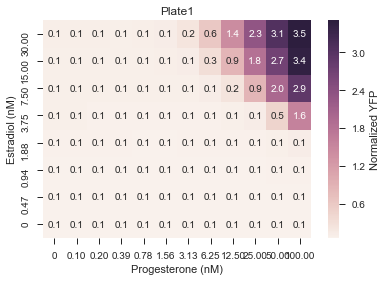

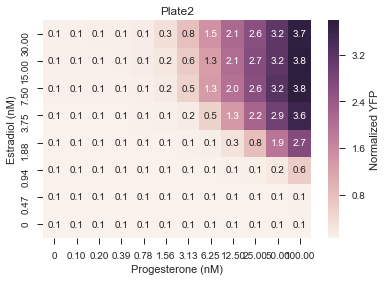

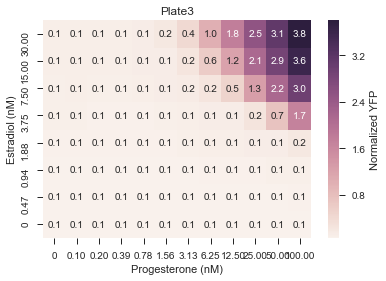

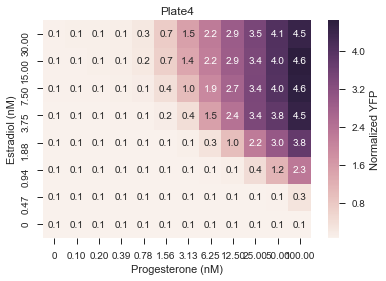

In [9]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

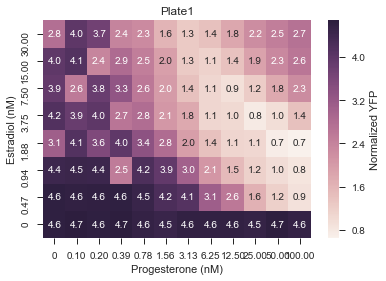

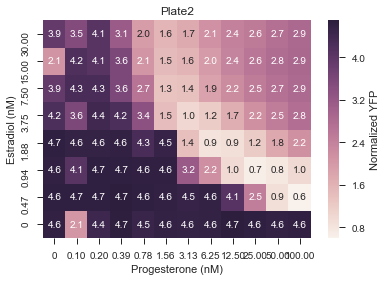

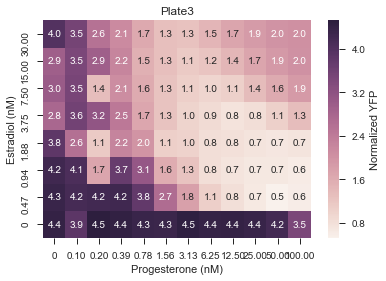

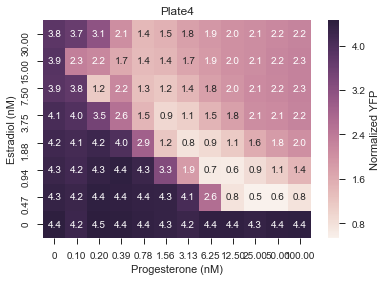

In [10]:
for plate in strains:
    sns.heatmap(FITCnorm[plate].cv.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized YFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'YFPCVheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

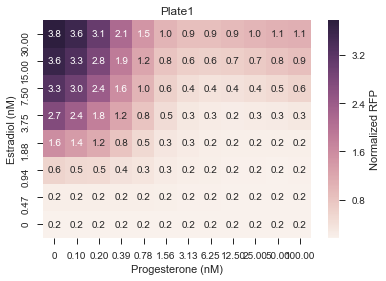

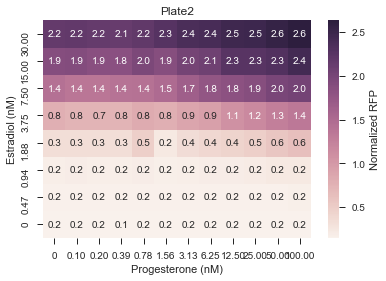

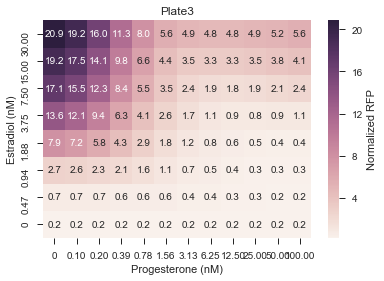

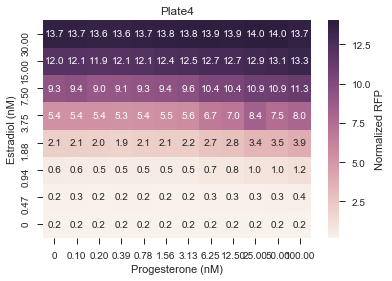

In [11]:
for plate in strains:
    sns.heatmap(RFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized RFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'RFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

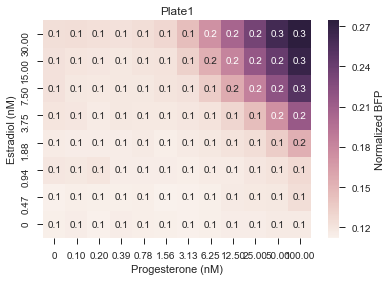

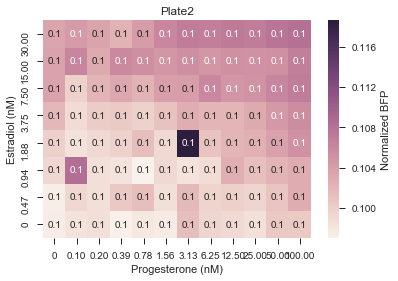

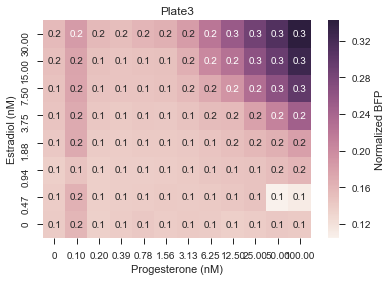

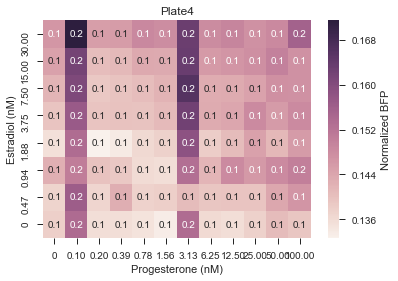

In [12]:
for plate in strains:
    sns.heatmap(BFPnorm[plate].med.iloc[:,::-1].astype(float),xticklabels = Pconc[::-1],yticklabels = Econc,annot=True,fmt='.1f',cbar_kws={'label': 'Normalized BFP'})
    plt.title(plate)
    plt.xlabel('Progesterone (nM)')
    plt.ylabel('Estradiol (nM)')

    dest = date + plate + 'BFPheatmap'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

## Work up histograms of the data in a 96 well plate format

In [16]:
FITCclean = pd.DataFrame(index = rows, columns = cols)
logFITCclean = pd.DataFrame(index = rows, columns = cols)

for row in rows:
    for col in cols:
        try:
            FITCclean.loc[row,col] = cleandata(allplates['767t1'].loc[row,col].data['FITC-A'].values,100)
            logFITCclean.loc[row,col] = np.log10(cleandata(allplates['767t1'].loc[row,col].data['FITC-A'].values,100))
        except:
            continue

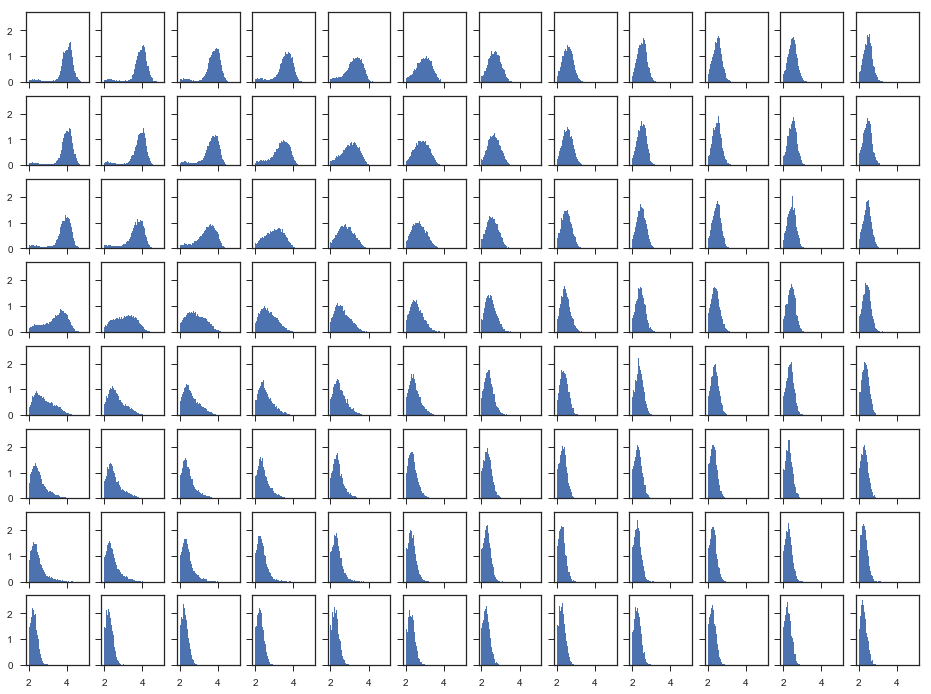

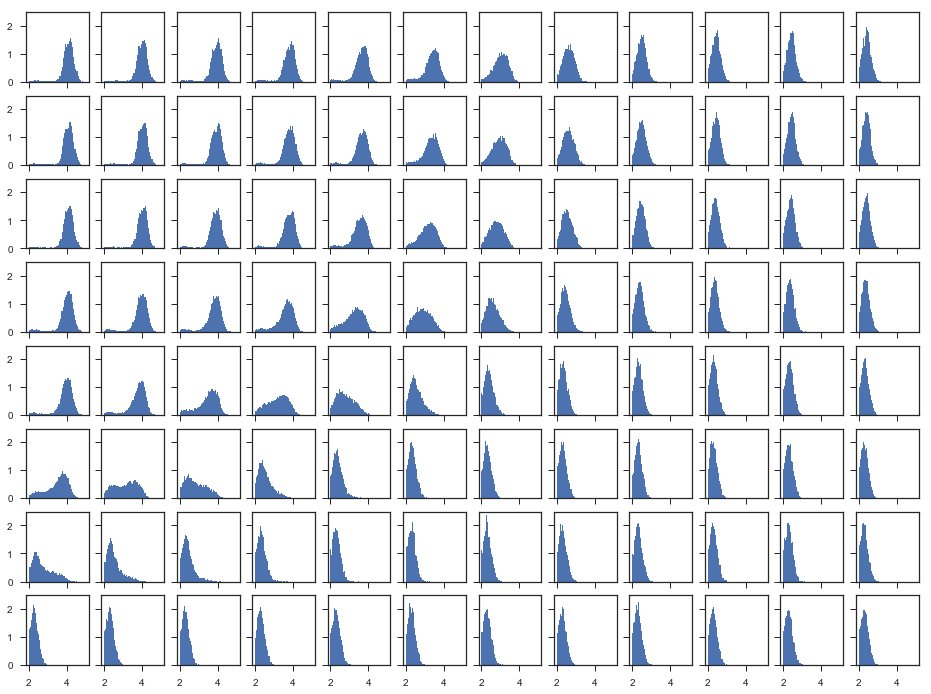

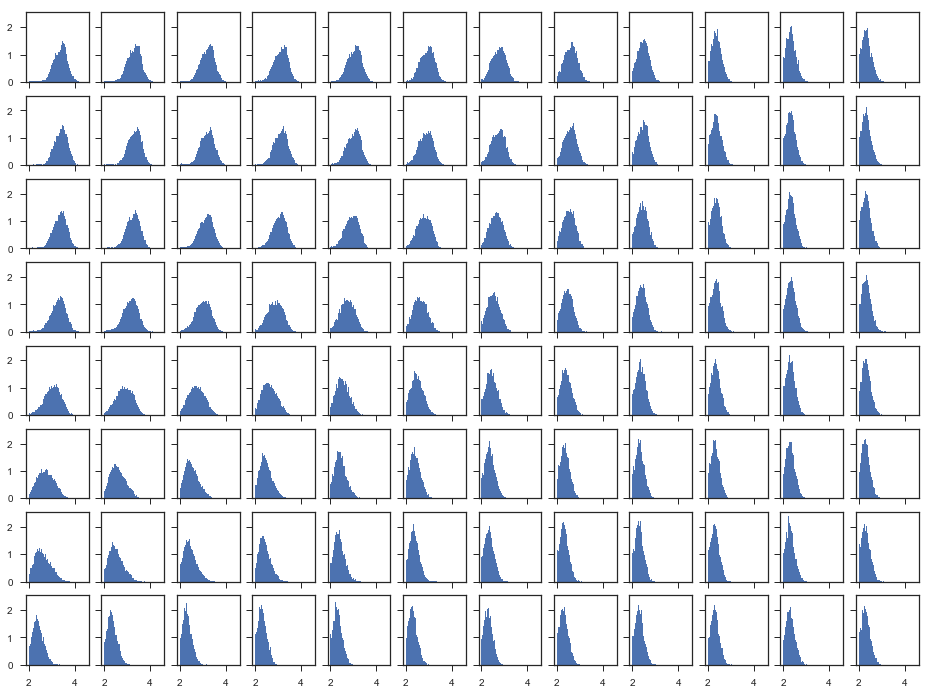

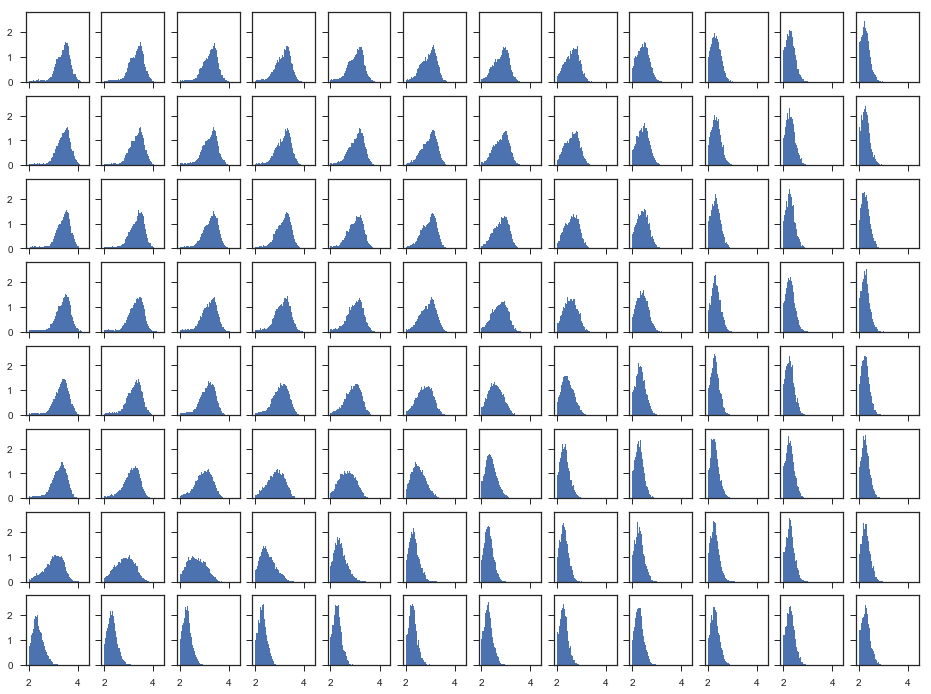

In [9]:
for plate in strains:
    FITCclean = pd.DataFrame(index = rows, columns = cols)
    logFITCclean = pd.DataFrame(index = rows, columns = cols)

    for row in rows:
        for col in cols:
            try:
                FITCclean.loc[row,col] = cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100)
                logFITCclean.loc[row,col] = np.log10(cleandata(allplates[plate].loc[row,col].data['FITC-A'].values,100))
            except:
                continue

    FITC_bincenter = pd.DataFrame(index = rows, columns = cols)
    FITC_histy = pd.DataFrame(index = rows, columns = cols)

    fig, ax = plt.subplots(8, 12,sharex = True, sharey = True, figsize=(16,12))

    for i in range(8):
        for j in range(12):
            try:
                FITC_histy.iloc[i,j],FITC_bincenter.iloc[i,j] = ax[i,j].hist(logFITCclean.iloc[i,j][~np.isnan(logFITCclean.iloc[i,j])],50,normed=1)
            except:
                continue

    dest = date + plate + 'fullhist'
    plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
    plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)
    plt.show()
    plt.close()

In [18]:
plt.set_cmap('plasma')

# Compare the effects of feedback

In [15]:
Econc

['30.00', '15.00', '7.50', '3.75', '1.88', '0.94', '0.47', 0]

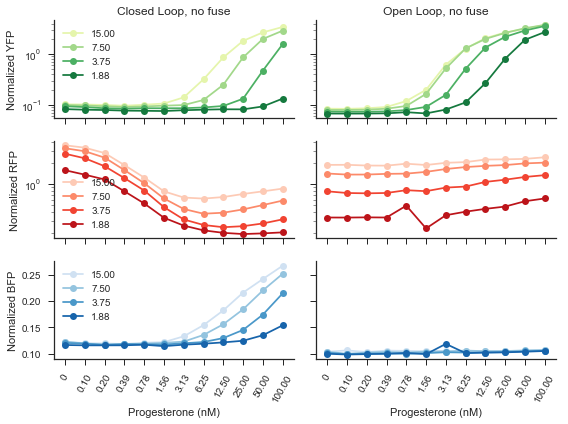

In [13]:
fig, ax = plt.subplots(3, 2,sharex=True,sharey='row',figsize=(8,6))

Greens = sns.color_palette('YlGn',4)
Reds = sns.color_palette('Reds',4)
Blues = sns.color_palette('Blues',4)

for i in range(4):
    #Plot YFP values
    ax[0,0].plot(Pconcind,FITCnorm['Plate1'].med.iloc[i+1,::-1],'o-', color = Greens[i],label=Econc[i+1])
    ax[0,1].plot(Pconcind,FITCnorm['Plate2'].med.iloc[i+1,::-1],'o-', color = Greens[i],label=Econc[i+1])

    #Plot RFP values
    ax[1,0].plot(Pconcind,RFPnorm['Plate1'].med.iloc[i+1,::-1],'o-', color = Reds[i], label=Econc[i+1])
    ax[1,1].plot(Pconcind,RFPnorm['Plate2'].med.iloc[i+1,::-1],'o-', color = Reds[i], label=Econc[i+1])
    
    #Plot BFP values
    ax[2,0].plot(Pconcind,BFPnorm['Plate1'].med.iloc[i+1,::-1],'o-', color = Blues[i], label=Econc[i+1])
    ax[2,1].plot(Pconcind,BFPnorm['Plate2'].med.iloc[i+1,::-1],'o-', color = Blues[i], label=Econc[i+1])

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')

for i in range(3):
    ax[i,0].legend()

ax[1,0].set_ylabel('Normalized RFP')
ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

ax[2,0].set_xlabel('Progesterone (nM)')
ax[2,0].set_xticks(Pconcind)
ax[2,0].set_xticklabels(Pconc[::-1],rotation = 60)

ax[2,1].set_xlabel('Progesterone (nM)')
ax[2,1].set_xticks(Pconcind)
ax[2,1].set_xticklabels(Pconc[::-1],rotation = 60)

ax[0,0].set_title('Closed Loop, no fuse')
ax[0,1].set_title('Open Loop, no fuse')


# Pad margins so that markers don't get clipped by the axes
#plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'YRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

In [14]:
CL_FITC_norm = pd.DataFrame(index = rows, columns = cols)
OL_FITC_norm = pd.DataFrame(index = rows, columns = cols)

CL_RFP_norm = pd.DataFrame(index = rows, columns = cols)
OL_RFP_norm = pd.DataFrame(index = rows, columns = cols)

for i in range(8):
    CL_FITC_norm.set_value(rows[i], cols[::-1], FITCnorm['Plate1'].med.iloc[i,::-1]/FITCnorm['Plate1'].med.iloc[i,7])
    OL_FITC_norm.set_value(rows[i], cols[::-1], FITCnorm['Plate2'].med.iloc[i,::-1]/FITCnorm['Plate1'].med.iloc[i,7])
    
    CL_RFP_norm.set_value(rows[i], cols[::-1], RFPnorm['Plate1'].med.iloc[i,::-1]/RFPnorm['Plate1'].med.iloc[i,7])
    OL_RFP_norm.set_value(rows[i], cols[::-1], RFPnorm['Plate2'].med.iloc[i,::-1]/RFPnorm['Plate1'].med.iloc[i,7])

In [15]:
FITCnorm['Plate1'].med.iloc[:,::-1]/FITCnorm['Plate1'].med.iloc[7,11]

,12,11,10,09,08,07,06,05,04,03,02,01
A,1.6375,1.63638,1.62505,1.60898,1.71626,2.09786,3.54187,9.65643,22.4595,36.4746,47.907,54.8687
B,1.59683,1.58353,1.55256,1.4983,1.56734,1.65649,2.18968,4.98549,13.4843,28.5894,42.0305,53.7838
C,1.54859,1.5153,1.46606,1.41575,1.45035,1.50165,1.5439,1.94555,3.88686,13.4755,31.2139,45.4022
D,1.46033,1.40906,1.33593,1.31023,1.33761,1.33421,1.33822,1.38472,1.48189,2.05811,7.38509,24.628
E,1.28332,1.25011,1.23207,1.19798,1.18925,1.17682,1.22098,1.25208,1.27419,1.27034,1.44928,2.06967
F,1.11653,1.10944,1.10457,1.09875,1.0944,1.09047,1.08919,1.1246,1.1419,1.16668,1.19861,1.23871
G,1.02558,1.03338,1.0271,1.03154,1.03363,1.03927,1.03345,1.05171,1.06506,1.10391,1.10732,1.14369
H,1,0.997143,1.00395,1.00436,1.00264,1.001,1.00087,1.00469,0.99732,1.00771,0.996874,0.982927


In [16]:
CL_FITC_norm

,01,02,03,04,05,06,07,08,09,10,11,12
A,31.9699,27.9136,21.2524,13.0863,5.62644,2.06371,1.22235,1,0.937493,0.946855,0.95346,0.954107
B,34.3152,26.8164,18.2406,8.60327,3.18085,1.39707,1.05688,1,0.955945,0.990565,1.01033,1.01882
C,31.3043,21.5216,9.29121,2.67995,1.34143,1.0645,1.03537,1,0.976142,1.01083,1.04478,1.06774
D,18.4119,5.52112,1.53865,1.10787,1.03522,1.00046,0.997461,1,0.97953,0.998745,1.05342,1.09174
E,1.74032,1.21865,1.06818,1.07142,1.05283,1.02668,0.989545,1,1.00734,1.036,1.05117,1.0791
F,1.13187,1.09522,1.06604,1.0434,1.0276,0.995244,0.996409,1,1.00398,1.0093,1.01375,1.02022
G,1.10649,1.0713,1.068,1.03041,1.01749,0.999829,1.00546,1,0.997982,0.993685,0.999759,0.992213
H,0.980343,0.994254,1.00506,0.994699,1.00205,0.998242,0.998374,1,1.00172,1.00131,0.994522,0.997372


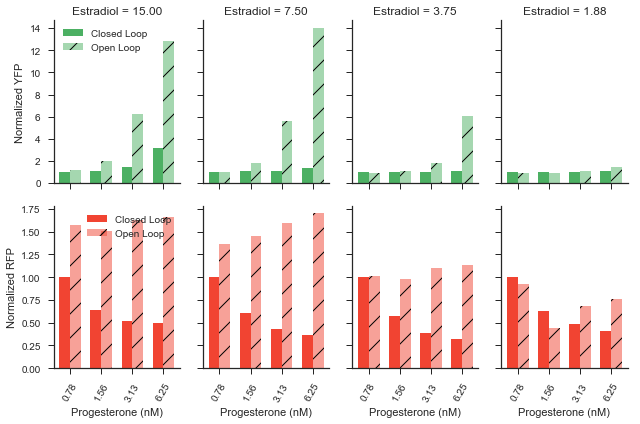

In [17]:
fig, ax = plt.subplots(2, 4,sharex=True,sharey='row',figsize=(9,6))

Greens = sns.color_palette('YlGn',4)
Reds = sns.color_palette('Reds',4)
Blues = sns.color_palette('Blues',4)

bar_width = 0.35
index = np.arange(4)
opacity = 0.5

for i in range(4):
    #Plot YFP values
    CLYFP = CL_FITC_norm.iloc[i+1,4:8]
    OLYFP = OL_FITC_norm.iloc[i+1,4:8]
    ax[0,i].bar(index[::-1],CL_FITC_norm.iloc[i+1,4:8], bar_width, color = Greens[2],label='Closed Loop')
    ax[0,i].bar(index[::-1]+ bar_width,OL_FITC_norm.iloc[i+1,4:8], bar_width, alpha=opacity, hatch="/", color = Greens[2],label='Open Loop')

    #Plot RFP values
    ax[1,i].bar(index[::-1],CL_RFP_norm.iloc[i+1,4:8], bar_width, color = Reds[2], label='Closed Loop')
    ax[1,i].bar(index[::-1]+ bar_width,OL_RFP_norm.iloc[i+1,4:8], bar_width, alpha=opacity, hatch="/",  color = Reds[2], label='Open Loop')

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
#ax[0,0].set_yscale('log')

for i in range(2):
    ax[i,0].legend()

ax[1,0].set_ylabel('Normalized RFP')
#ax[1,0].set_yscale('log')

for i in range(4):
    ax[1,i].set_xlabel('Progesterone (nM)')
    ax[1,i].set_xticks(index[::-1] + bar_width/2)
    ax[1,i].set_xticklabels(Pconc[4:8],rotation = 60)
    ax[0,i].set_title('Estradiol = ' + Econc[i+1])

# Pad margins so that markers don't get clipped by the axes
#plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'normYRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

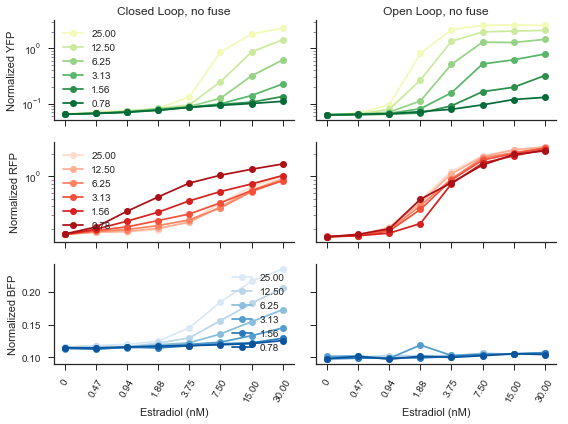

In [18]:
fig, ax = plt.subplots(3, 2,sharex=True,sharey='row',figsize=(8,6))

Greens = sns.color_palette('YlGn',6)
Reds = sns.color_palette('Reds',6)
Blues = sns.color_palette('Blues',6)

for i in range(6):
    #Plot YFP values
    ax[0,0].plot(Econcind,FITCnorm['Plate1'].med.iloc[::-1,i+2],'o-', color = Greens[i],label=Pconc[i+2])
    ax[0,1].plot(Econcind,FITCnorm['Plate2'].med.iloc[::-1,i+2],'o-', color = Greens[i],label=Pconc[i+2])

    #Plot RFP values
    ax[1,0].plot(Econcind,RFPnorm['Plate1'].med.iloc[::-1,i+2],'o-', color = Reds[i], label=Pconc[i+2])
    ax[1,1].plot(Econcind,RFPnorm['Plate2'].med.iloc[::-1,i+2],'o-', color = Reds[i], label=Pconc[i+2])
    
    #Plot BFP values
    ax[2,0].plot(Econcind,BFPnorm['Plate1'].med.iloc[::-1,i+2],'o-', color = Blues[i], label=Pconc[i+2])
    ax[2,1].plot(Econcind,BFPnorm['Plate2'].med.iloc[::-1,i+2],'o-', color = Blues[i], label=Pconc[i+2])

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')

for i in range(3):
    ax[i,0].legend()

ax[1,0].set_ylabel('Normalized RFP')
ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

ax[2,0].set_xlabel('Estradiol (nM)')
ax[2,0].set_xticks(Econcind)
ax[2,0].set_xticklabels(Econc[::-1],rotation = 60)

ax[2,1].set_xlabel('Estradiol (nM)')
ax[2,1].set_xticks(Econcind)
ax[2,1].set_xticklabels(Econc[::-1],rotation = 60)

ax[0,0].set_title('Closed Loop, no fuse')
ax[0,1].set_title('Open Loop, no fuse')


# Pad margins so that markers don't get clipped by the axes
#plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'E2YRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

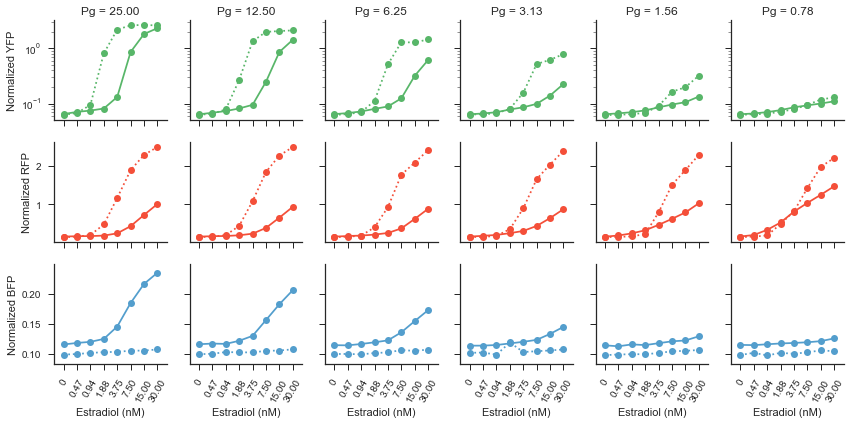

In [19]:
fig, ax = plt.subplots(3, 6,sharex=True,sharey='row',figsize=(12,6))

for j in range(6):
    ax[0,j].plot(Econcind,FITCnorm['Plate1'].med.iloc[::-1,j+2],'o-', color = Greens[3])
    ax[1,j].plot(Econcind,RFPnorm['Plate1'].med.iloc[::-1,j+2],'o-', color = Reds[3])
    ax[2,j].plot(Econcind,BFPnorm['Plate1'].med.iloc[::-1,j+2],'o-', color = Blues[3])
    
    ax[0,j].plot(Econcind,FITCnorm['Plate2'].med.iloc[::-1,j+2],'o:', color = Greens[3])
    ax[1,j].plot(Econcind,RFPnorm['Plate2'].med.iloc[::-1,j+2],'o:', color = Reds[3])
    ax[2,j].plot(Econcind,BFPnorm['Plate2'].med.iloc[::-1,j+2],'o:', color = Blues[3])
        

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')

ax[1,0].set_ylabel('Normalized RFP')
#ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

for i in range(6):
    ax[2,i].set_xlabel('Estradiol (nM)')
    ax[2,i].set_xticks(Econcind)
    ax[2,i].set_xticklabels(Econc[::-1],rotation = 60)
    ax[0,i].set_title('Pg = ' + Pconc[i+2])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'E2singleYRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

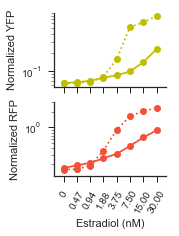

In [20]:
fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(2,3))

ax[0].plot(Econcind,FITCnorm['Plate1'].med.iloc[::-1,5 ],'o-', color = 'y')
ax[1].plot(Econcind,RFPnorm['Plate1'].med.iloc[::-1,5],'o-', color = Reds[3])

ax[0].plot(Econcind,FITCnorm['Plate2'].med.iloc[::-1,5],'o:', color = 'y')
ax[1].plot(Econcind,RFPnorm['Plate2'].med.iloc[::-1,5],'o:', color = Reds[3])

ax[0].set_ylabel('Normalized YFP')
ax[0].set_yscale('log')

ax[1].set_ylabel('Normalized RFP')
ax[1].set_yscale('log')


ax[1].set_xlabel('Estradiol (nM)')
ax[1].set_xticks(Econcind)
ax[1].set_xticklabels(Econc[::-1],rotation = 60)
#ax[0,i].set_title('Pg = ' + Pconc[i+2])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'oneE2singleYRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

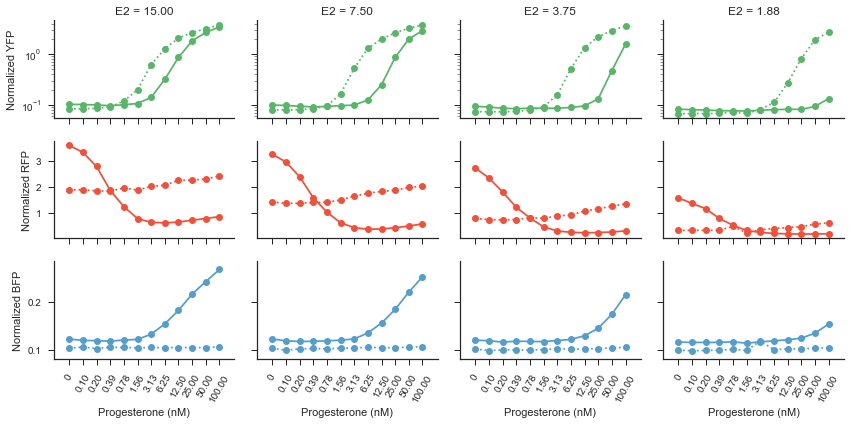

In [22]:
fig, ax = plt.subplots(3, 4,sharex=True,sharey='row',figsize=(12,6))

for j in range(4):
    ax[0,j].plot(Pconcind,FITCnorm['Plate1'].med.iloc[j+1,::-1],'o-', color = Greens[3])
    ax[1,j].plot(Pconcind,RFPnorm['Plate1'].med.iloc[j+1,::-1],'o-', color = Reds[3])
    ax[2,j].plot(Pconcind,BFPnorm['Plate1'].med.iloc[j+1,::-1],'o-', color = Blues[3])
    
    ax[0,j].plot(Pconcind,FITCnorm['Plate2'].med.iloc[j+1,::-1],'o:', color = Greens[3])
    ax[1,j].plot(Pconcind,RFPnorm['Plate2'].med.iloc[j+1,::-1],'o:', color = Reds[3])
    ax[2,j].plot(Pconcind,BFPnorm['Plate2'].med.iloc[j+1,::-1],'o:', color = Blues[3])
        

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')

ax[1,0].set_ylabel('Normalized RFP')
#ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

for i in range(4):
    ax[2,i].set_xlabel('Progesterone (nM)')
    ax[2,i].set_xticks(Pconcind)
    ax[2,i].set_xticklabels(Pconc[::-1],rotation = 60)
    ax[0,i].set_title('E2 = ' + Econc[i+1])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'singleYRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

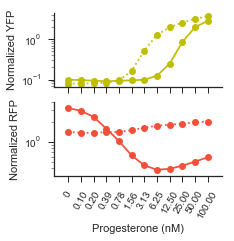

In [23]:
fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(3,3))

ax[0].plot(Pconcind,FITCnorm['Plate1'].med.iloc[2,::-1],'o-', color = 'y')
ax[1].plot(Pconcind,RFPnorm['Plate1'].med.iloc[2,::-1],'o-', color = Reds[3])

ax[0].plot(Pconcind,FITCnorm['Plate2'].med.iloc[2,::-1],'o:', color = 'y')
ax[1].plot(Pconcind,RFPnorm['Plate2'].med.iloc[2,::-1],'o:', color = Reds[3])        

#ax[0,0].set_yscale('log')
ax[0].set_ylabel('Normalized YFP')
ax[0].set_yscale('log')

ax[1].set_ylabel('Normalized RFP')
ax[1].set_yscale('log')

ax[1].set_xlabel('Progesterone (nM)')
ax[1].set_xticks(Pconcind)
ax[1].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'onePgsingleYRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

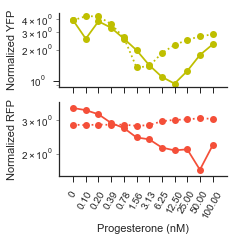

In [24]:
fig, ax = plt.subplots(2, 1,sharex=True,sharey='row',figsize=(3,3))

ax[0].plot(Pconcind,FITCnorm['Plate1'].cv.iloc[2,::-1],'o-', color = 'y')
ax[1].plot(Pconcind,RFPnorm['Plate1'].cv.iloc[2,::-1],'o-', color = Reds[3])

ax[0].plot(Pconcind,FITCnorm['Plate2'].cv.iloc[2,::-1],'o:', color = 'y')
ax[1].plot(Pconcind,RFPnorm['Plate2'].cv.iloc[2,::-1],'o:', color = Reds[3])        

#ax[0,0].set_yscale('log')
ax[0].set_ylabel('Normalized YFP')
ax[0].set_yscale('log')

ax[1].set_ylabel('Normalized RFP')
ax[1].set_yscale('log')

ax[1].set_xlabel('Progesterone (nM)')
ax[1].set_xticks(Pconcind)
ax[1].set_xticklabels(Pconc[::-1],rotation = 60)

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
#plt.tight_layout()
    
sns.despine()

dest = date + 'onePgsingleYR_CV_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

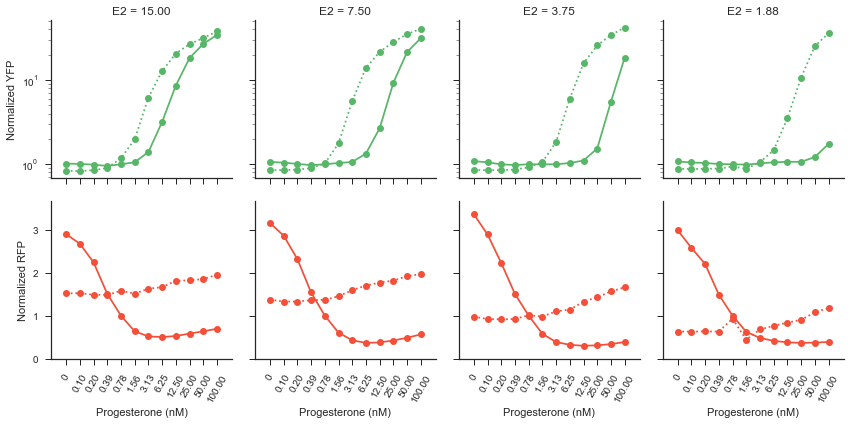

In [25]:
fig, ax = plt.subplots(2, 4,sharex=True,sharey='row',figsize=(12,6))

for j in range(4):
    ax[0,j].plot(Pconcind,CL_FITC_norm.iloc[j+1,::-1],'o-', color = Greens[3])
    ax[1,j].plot(Pconcind,CL_RFP_norm.iloc[j+1,::-1],'o-', color = Reds[3])
    
    ax[0,j].plot(Pconcind,OL_FITC_norm.iloc[j+1,::-1],'o:', color = Greens[3])
    ax[1,j].plot(Pconcind,OL_RFP_norm.iloc[j+1,::-1],'o:', color = Reds[3])        

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')

ax[1,0].set_ylabel('Normalized RFP')
#ax[1,0].set_yscale('log')

for i in range(4):
    ax[1,i].set_xlabel('Progesterone (nM)')
    ax[1,i].set_xticks(Pconcind)
    ax[1,i].set_xticklabels(Pconc[::-1],rotation = 60)
    ax[0,i].set_title('E2 = ' + Econc[i+1])

# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'normsingleYRBcomparison_nofuse'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

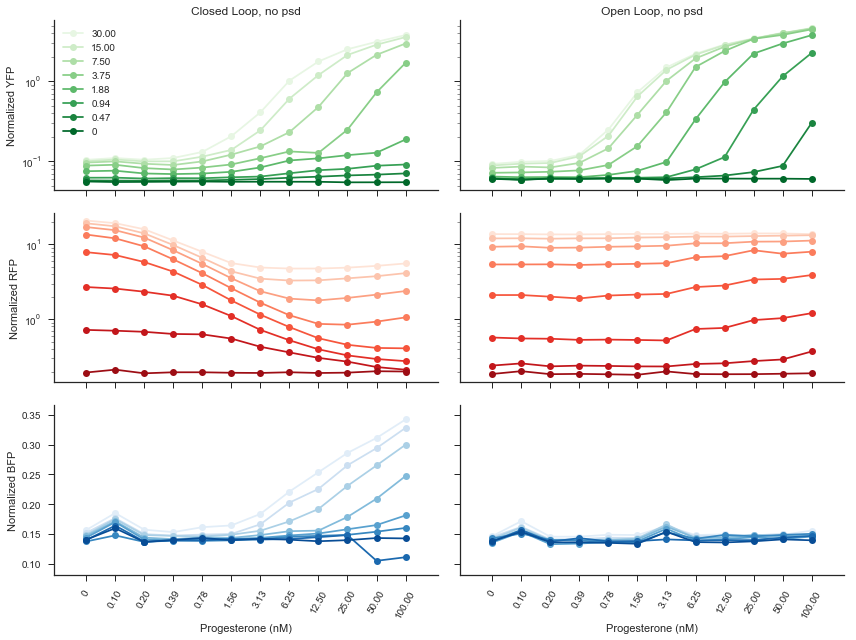

In [32]:
fig, ax = plt.subplots(3, 2,sharex=True,sharey='row',figsize=(12,9))

Greens = sns.color_palette('Greens',8)
Reds = sns.color_palette('Reds',8)
Blues = sns.color_palette('Blues',8)

for i in range(8):
    #Plot YFP values
    ax[0,0].plot(Pconcind,FITCnorm['Plate3'].med.iloc[i,::-1],'o-', color = Greens[i],label=Econc[i])
    ax[0,1].plot(Pconcind,FITCnorm['Plate4'].med.iloc[i,::-1],'o-', color = Greens[i],label=Econc[i])

    #Plot RFP values
    ax[1,0].plot(Pconcind,RFPnorm['Plate3'].med.iloc[i,::-1],'o-', color = Reds[i], label=Econc[i])
    ax[1,1].plot(Pconcind,RFPnorm['Plate4'].med.iloc[i,::-1],'o-', color = Reds[i], label=Econc[i])
    
    #Plot BFP values
    ax[2,0].plot(Pconcind,BFPnorm['Plate3'].med.iloc[i,::-1],'o-', color = Blues[i], label=Econc[i])
    ax[2,1].plot(Pconcind,BFPnorm['Plate4'].med.iloc[i,::-1],'o-', color = Blues[i], label=Econc[i])

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[1,0].set_ylabel('Normalized RFP')
ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

ax[2,0].set_xlabel('Progesterone (nM)')
ax[2,0].set_xticks(Pconcind)
ax[2,0].set_xticklabels(Pconc[::-1],rotation = 60)

ax[2,1].set_xlabel('Progesterone (nM)')
ax[2,1].set_xticks(Pconcind)
ax[2,1].set_xticklabels(Pconc[::-1],rotation = 60)

ax[0,0].set_title('Closed Loop, no psd')
ax[0,1].set_title('Open Loop, no psd')


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'YRBcomparison_nopsd'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()

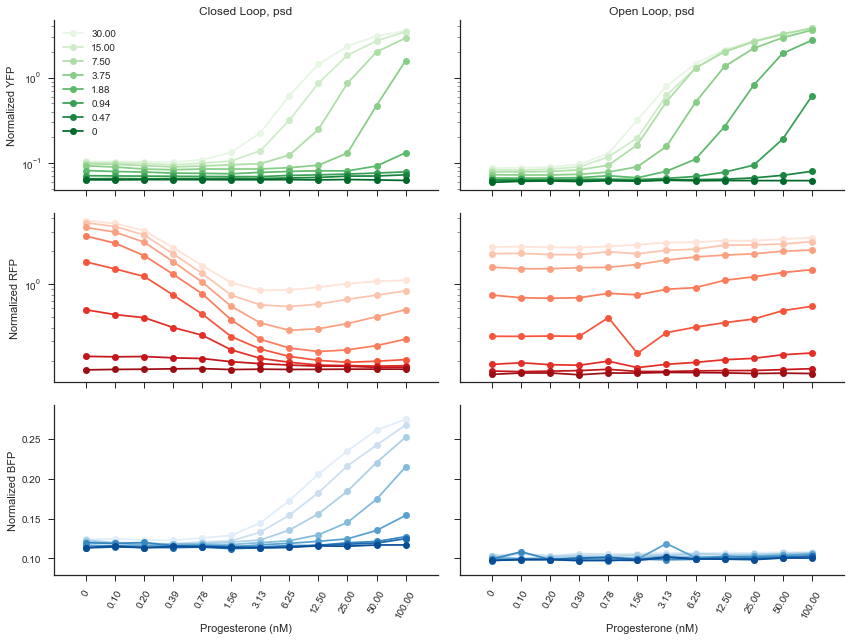

In [31]:
fig, ax = plt.subplots(3, 2,sharex=True,sharey='row',figsize=(12,9))

Greens = sns.color_palette('Greens',8)
Reds = sns.color_palette('Reds',8)
Blues = sns.color_palette('Blues',8)

for i in range(8):
    #Plot YFP values
    ax[0,0].plot(Pconcind,FITCnorm['Plate1'].med.iloc[i,::-1],'o-', color = Greens[i],label=Econc[i])
    ax[0,1].plot(Pconcind,FITCnorm['Plate2'].med.iloc[i,::-1],'o-', color = Greens[i],label=Econc[i])

    #Plot RFP values
    ax[1,0].plot(Pconcind,RFPnorm['Plate1'].med.iloc[i,::-1],'o-', color = Reds[i], label=Econc[i])
    ax[1,1].plot(Pconcind,RFPnorm['Plate2'].med.iloc[i,::-1],'o-', color = Reds[i], label=Econc[i])
    
    #Plot BFP values
    ax[2,0].plot(Pconcind,BFPnorm['Plate1'].med.iloc[i,::-1],'o-', color = Blues[i], label=Econc[i])
    ax[2,1].plot(Pconcind,BFPnorm['Plate2'].med.iloc[i,::-1],'o-', color = Blues[i], label=Econc[i])

#ax[0,0].set_yscale('log')
ax[0,0].set_ylabel('Normalized YFP')
ax[0,0].set_yscale('log')
ax[0,0].legend()

ax[1,0].set_ylabel('Normalized RFP')
ax[1,0].set_yscale('log')

ax[2,0].set_ylabel('Normalized BFP')
#ax[2,0].set_yscale('log')

ax[2,0].set_xlabel('Progesterone (nM)')
ax[2,0].set_xticks(Pconcind)
ax[2,0].set_xticklabels(Pconc[::-1],rotation = 60)

ax[2,1].set_xlabel('Progesterone (nM)')
ax[2,1].set_xticks(Pconcind)
ax[2,1].set_xticklabels(Pconc[::-1],rotation = 60)

ax[0,0].set_title('Closed Loop, psd')
ax[0,1].set_title('Open Loop, psd')


# Pad margins so that markers don't get clipped by the axes
plt.margins(0.1)
plt.tight_layout()
    
sns.despine()

dest = date + 'YRBcomparison_psd'
plt.savefig(dest + '.svg', bbox_inches='tight',dpi=300)
plt.savefig(dest + '.png', bbox_inches='tight',dpi=300)

plt.show()
plt.close()